In [1]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    IN_COLAB = False
else:
    drive.mount('/content/drive')
    IN_COLAB = True

In [2]:
if IN_COLAB:
    TRIPS_PATH = "/content/drive/MyDrive/Project/"
else:
    TRIPS_PATH = "../../data/"
TRIPS_PATH += "SK_pollution.csv"

In [3]:
if IN_COLAB:
    REF_PATH = "/content/drive/MyDrive/Project/"
else:
    REF_PATH = "../../data/"
REF_PATH += "Average pm25 per neighborhood BASELINE SK.csv"

In [4]:
import pandas as pd
import folium
import geopandas as gpd
from datetime import datetime
import numpy as np
from shapely.geometry import Polygon
import math
import matplotlib.pyplot as plt
from shapely import wkt

from s2 import s2

C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\3530501325.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data Preprocessing

In [5]:
trips = pd.read_csv(TRIPS_PATH)
trips.rename(columns={'Address': 'District', 'PM2.5': 'pm25'}, inplace=True)
trips['District'] = trips['District'].apply(lambda x: x.split(',')[2])
trips.head(1)

,Measurement date,Station code,District,Latitude,Longitude,SO2,NO2,O3,CO,PM10,pm25
0,2017-01-01 00:00,101,Jongno-gu,37.572016,127.005008,0.004,0.059,0.002,1.2,73.0,57.0


# Neighborhood Approximation

## <font color = 'blue'> Fixed Resolution and Variable Size </font>

### <font color = 'green'>- RMSE </font>

In [9]:
s2_resolution = 14

In [7]:
# Filter trips with corresponding neighborhoods in NYC
trips = gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.Longitude, trips.Latitude), crs='epsg:4326')

In [12]:
trips['s2'] = trips.apply(lambda x: s2.geo_to_s2(x.Latitude, x.Longitude, s2_resolution), axis = 1)

In [13]:
reference_value = pd.read_csv(REF_PATH)
reference_value = gpd.GeoDataFrame(reference_value)
print(reference_value['District'].nunique())
print(len(reference_value['District']))

25
25


In [14]:
def calculate_rmse(predicted_values, actual_values):
    # Calculate squared differences
    squared_diff = (predicted_values - actual_values) ** 2
    
    # Calculate mean squared differences
    mean_squared_diff = np.mean(squared_diff)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_diff)
    
    return rmse

In [15]:
def get_rmse_s2(baseline, encoded):
    error = []
    for sampling_frequency in np.arange(0.1,1.1,0.1):
        sampled_trips = encoded.groupby('s2').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
        df_enc_pm25 = (sampled_trips
                          .groupby('s2')
                          .pm25
                          .agg(list)
                          .to_frame("pm25_list")
                          .reset_index())  # Make a list of pm25 values for each s2 cell
        df_enc_pm25['average_pm25_value'] = df_enc_pm25['pm25_list'].apply(lambda x:sum(x)/len(x)) #Find the average pm25 value for each s2 cell
        df_enc_pm25.drop('pm25_list', axis = 1, inplace=True)
        sampled_trips_with_neighborhood_pm25 = pd.merge(sampled_trips, baseline, on='District', how='inner')
        sampled_trips_with_enc_geometry_pm25 = pd.merge(sampled_trips, df_enc_pm25, on='s2', how='inner')
        assert sampled_trips_with_neighborhood_pm25.shape[0] == sampled_trips_with_enc_geometry_pm25.shape[0]
        columns = list(sampled_trips.columns)
        sampled_trips_with_neighborhood_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_neighborhood_pm25.reset_index(drop=True, inplace=True)
        sampled_trips_with_enc_geometry_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_enc_geometry_pm25.reset_index(drop=True, inplace=True)
        baseline_pm25 = sampled_trips_with_neighborhood_pm25["average_pm25_value"].values
        sampled_pm25  = sampled_trips_with_enc_geometry_pm25["average_pm25_value"].values
        rmse = calculate_rmse(sampled_pm25, baseline_pm25)
        error.append(rmse)
    return error

In [17]:
RMSE_S2 = get_rmse_s2(reference_value,trips)

C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\2610336549.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_trips = encoded.groupby('s2').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\2610336549.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_trips = encoded.groupby('s2').apply(lambda 

In [18]:
RMSE_S2

[0.6576977593057721,
 0.5535049499942194,
 0.45433104780829353,
 0.25357386651614705,
 0.30807251349893855,
 0.23688851517266615,
 0.18352972475796195,
 0.1471335669254128,
 0.07208710208284344,
 1.7404859584931204e-15]

<Figure size 640x480 with 0 Axes>

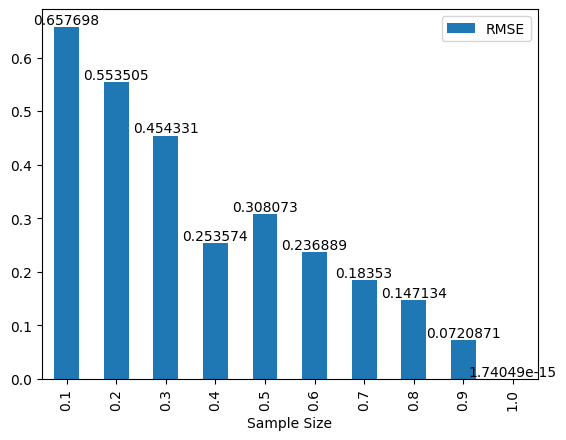

In [19]:
H3_Performance = pd.DataFrame({'Sample Size':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
                               'RMSE': RMSE_S2})
plt.figure()
ax = H3_Performance.plot(kind='bar', x='Sample Size', y= 'RMSE')
ax.bar_label(ax.containers[0], color = 'black')
plt.show()

### <font color = 'green'>- MAPE </font>

In [20]:
s2_resolution = 14

In [21]:
def calculate_mape(predicted_values, actual_values):
    # Calculate absolute differences
    absolute_diff = np.abs(actual_values - predicted_values)
    
    # Calculate percentage error
    percentage_error = absolute_diff / actual_values
    
    # Handle cases where actual values are 0 to avoid division by zero
    percentage_error = np.nan_to_num(percentage_error, nan=0, posinf=0)
    
    # Calculate mean percentage error
    mean_percentage_error = np.mean(percentage_error)
    
    # Convert mean percentage error to percentage
    mape = mean_percentage_error * 100
    
    return mape

In [22]:
def get_mape_s2(baseline, encoded):
    error = []
    for sampling_frequency in np.arange(0.1,1.1,0.1):
        sampled_trips = encoded.groupby('s2').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
        df_enc_pm25 = (sampled_trips
                          .groupby('s2')
                          .pm25
                          .agg(list)
                          .to_frame("pm25_list")
                          .reset_index())  # Make a list of pm25 values for each s2 cell
        df_enc_pm25['average_pm25_value'] = df_enc_pm25['pm25_list'].apply(lambda x:sum(x)/len(x)) #Find the average pm25 value for each s2 cell
        df_enc_pm25.drop('pm25_list', axis = 1, inplace=True)
        sampled_trips_with_neighborhood_pm25 = pd.merge(sampled_trips, baseline, on='District', how='inner')
        sampled_trips_with_enc_geometry_pm25 = pd.merge(sampled_trips, df_enc_pm25, on='s2', how='inner')
        assert sampled_trips_with_neighborhood_pm25.shape[0] == sampled_trips_with_enc_geometry_pm25.shape[0]
        columns = list(sampled_trips.columns)
        sampled_trips_with_neighborhood_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_neighborhood_pm25.reset_index(drop=True, inplace=True)
        sampled_trips_with_enc_geometry_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_enc_geometry_pm25.reset_index(drop=True, inplace=True)
        baseline_pm25 = sampled_trips_with_neighborhood_pm25["average_pm25_value"].values
        sampled_pm25  = sampled_trips_with_enc_geometry_pm25["average_pm25_value"].values
        mape = calculate_mape(sampled_pm25, baseline_pm25)
        error.append(mape)
    return error

In [23]:
MAPE_S2 = get_mape_s2(reference_value,trips)

C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\3384393416.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_trips = encoded.groupby('s2').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\3384393416.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_trips = encoded.groupby('s2').apply(lambda 

In [24]:
MAPE_S2

[1.7610554344175817,
 1.4804810572646128,
 0.869422584069436,
 0.906903211692619,
 0.9760391665330421,
 0.8396455301252228,
 0.3579728925199787,
 0.4199962107810736,
 0.1496166863574953,
 3.356156612226708e-15]

<Figure size 640x480 with 0 Axes>

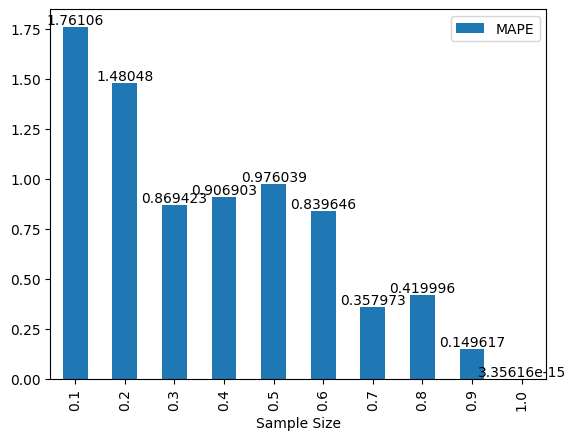

In [25]:
H3_Performance = pd.DataFrame({'Sample Size':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
                               'MAPE': MAPE_S2})
plt.figure()
ax = H3_Performance.plot(kind='bar', x='Sample Size', y= 'MAPE')
ax.bar_label(ax.containers[0], color = 'black')
plt.show()

## <font color = 'blue'> Fixed Size and Variable Resolution </font>

### <font color = 'green'>- RMSE </font>

In [26]:
s2_resolution_min = 0
s2_resolution_max = 30
sampling_frequency = 0.6

In [30]:
def group_by_s2(df, h3_resolution):
    df['s2'] = df.apply(lambda x: s2.geo_to_s2(x.Latitude, x.Longitude, s2_resolution), axis=1)
    return df.groupby('s2')

In [36]:
def get_rmse_s2(baseline, encoded):
    error = []
    s2_resolution = s2_resolution_min
    while s2_resolution <= s2_resolution_max:
        sampled_trips = group_by_s2(encoded, s2_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
        df_enc_pm25 = (sampled_trips
                          .groupby('s2')
                          .pm25
                          .agg(list)
                          .to_frame("pm25_list")
                          .reset_index())  # Make a list of pm25 values for each s2 cell
        df_enc_pm25['average_pm25_value'] = df_enc_pm25['pm25_list'].apply(lambda x:sum(x)/len(x)) #Find the average pm25 value for each s2 cell
        df_enc_pm25.drop('pm25_list', axis = 1, inplace=True)
        sampled_trips_with_neighborhood_pm25 = pd.merge(sampled_trips, baseline, on='District', how='inner')
        sampled_trips_with_enc_geometry_pm25 = pd.merge(sampled_trips, df_enc_pm25, on='s2', how='inner')
        assert sampled_trips_with_neighborhood_pm25.shape[0] == sampled_trips_with_enc_geometry_pm25.shape[0]
        columns = list(sampled_trips.columns)
        sampled_trips_with_neighborhood_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_neighborhood_pm25.reset_index(drop=True, inplace=True)
        sampled_trips_with_enc_geometry_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_enc_geometry_pm25.reset_index(drop=True, inplace=True)
        baseline_pm25 = sampled_trips_with_neighborhood_pm25["average_pm25_value"].values
        sampled_pm25  = sampled_trips_with_enc_geometry_pm25["average_pm25_value"].values
        rmse = calculate_rmse(sampled_pm25, baseline_pm25)
        error.append(rmse) #Append to Error list
        s2_resolution += 1
    return error

In [33]:
RMSE_S2 = get_rmse_s2(reference_value,trips)

C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\1072512912.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_trips = group_by_s2(encoded, h3_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\1072512912.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_trips = group_by_s2(encoded, 

In [34]:
RMSE_S2

[0.26813386470881456,
 0.23253289921851963,
 0.20345973411811838,
 0.21320329311617373,
 0.21742870756080374,
 0.3131184382667552,
 0.20738014280880768,
 0.24800215612532361,
 0.20611675732376203,
 0.2011263882493131,
 0.1580185192322157,
 0.19615159855955555,
 0.20007556644367322,
 0.22137484167486052,
 0.20736145788717736,
 0.20810034889095178,
 0.18153507525834675,
 0.22785832822834226,
 0.1674455124878664,
 0.18814043897395566,
 0.21089138959185663,
 0.25756900891258455,
 0.20071957702253737,
 0.19719009035474278,
 0.2650455785818735,
 0.18687167492909224,
 0.223688650471423,
 0.2305930471046256,
 0.16356872388149557,
 0.19852396181536142,
 0.2731545239420477]

<Figure size 640x480 with 0 Axes>

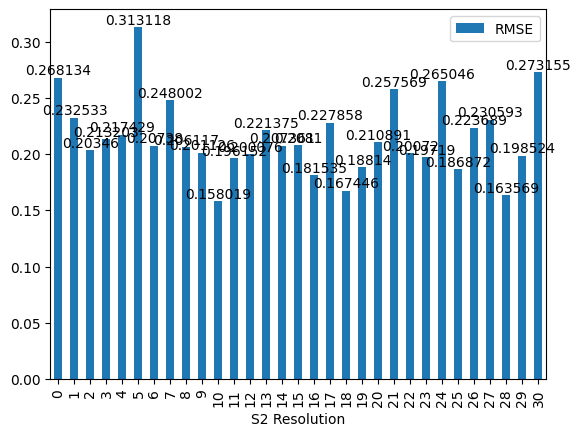

In [35]:
X_LABEL = 'S2 Resolution'
Y_LABEL = 'RMSE'
H3_Performance = pd.DataFrame({X_LABEL:list(range(s2_resolution_min, s2_resolution_max + 1)),
                               Y_LABEL: RMSE_S2})
plt.figure()
ax = H3_Performance.plot(kind='bar', x=X_LABEL, y=Y_LABEL)
ax.bar_label(ax.containers[0], color = 'black')
plt.show()

### <font color = 'green'>- MAPE </font>

In [31]:
s2_resolution_min = 0
s2_resolution_max = 30
sampling_frequency = 0.6

In [37]:
def get_mape_s2(baseline, encoded):
    error = []
    s2_resolution = s2_resolution_min
    while s2_resolution <= s2_resolution_max:
        sampled_trips = group_by_s2(encoded, s2_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
        df_enc_pm25 = (sampled_trips
                          .groupby('s2')
                          .pm25
                          .agg(list)
                          .to_frame("pm25_list")
                          .reset_index())  # Make a list of pm25 values for each s2 cell
        df_enc_pm25['average_pm25_value'] = df_enc_pm25['pm25_list'].apply(lambda x:sum(x)/len(x)) #Find the average pm25 value for each s2 cell
        df_enc_pm25.drop('pm25_list', axis = 1, inplace=True)
        sampled_trips_with_neighborhood_pm25 = pd.merge(sampled_trips, baseline, on='District', how='inner')
        sampled_trips_with_enc_geometry_pm25 = pd.merge(sampled_trips, df_enc_pm25, on='s2', how='inner')
        assert sampled_trips_with_neighborhood_pm25.shape[0] == sampled_trips_with_enc_geometry_pm25.shape[0]
        columns = list(sampled_trips.columns)
        sampled_trips_with_neighborhood_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_neighborhood_pm25.reset_index(drop=True, inplace=True)
        sampled_trips_with_enc_geometry_pm25.sort_values(by=columns, inplace=True)
        sampled_trips_with_enc_geometry_pm25.reset_index(drop=True, inplace=True)
        baseline_pm25 = sampled_trips_with_neighborhood_pm25["average_pm25_value"].values
        sampled_pm25  = sampled_trips_with_enc_geometry_pm25["average_pm25_value"].values
        mape = calculate_mape(sampled_pm25, baseline_pm25)
        error.append(mape) #Append to Error list
        s2_resolution += 1
    return error

In [38]:
MAPE_S2 = get_mape_s2(reference_value,trips)

C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\1708682475.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_trips = group_by_s2(encoded, s2_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\1708682475.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_trips = group_by_s2(encoded, 

In [39]:
MAPE_S2

[0.7216149123061826,
 0.6188462228348368,
 0.7183503157553697,
 0.5796832109731601,
 0.6284211443240292,
 0.48604192824527076,
 0.7028680265415257,
 0.5906635338971544,
 0.44257102193473175,
 0.4639321959361718,
 0.5391317788456238,
 0.643358522290208,
 0.5476309936374611,
 0.7974398208697346,
 0.4796955210387338,
 0.6303919113169306,
 0.5427466409717278,
 0.5553882490182342,
 0.5037385448971089,
 0.4844467415117796,
 0.49056722863741553,
 0.45749150214833545,
 0.7140656520821258,
 0.47796263281897977,
 0.6266879576598694,
 0.6003811882045594,
 0.5628715209747756,
 0.7142626544907841,
 0.4751899024456803,
 0.4064194122103221,
 0.7146198042435542]

<Figure size 640x480 with 0 Axes>

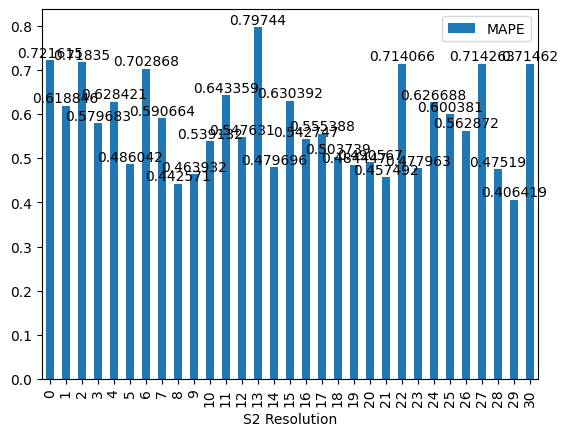

In [40]:
X_LABEL = 'S2 Resolution'
Y_LABEL = 'MAPE'
H3_Performance = pd.DataFrame({X_LABEL:list(range(s2_resolution_min, s2_resolution_max + 1)),
                               Y_LABEL: MAPE_S2})
plt.figure()
ax = H3_Performance.plot(kind='bar', x=X_LABEL, y=Y_LABEL)
ax.bar_label(ax.containers[0], color = 'black')
plt.show()

# Stratified Sampling

## <font color = 'blue'> Fixed Resolution and Variable Size </font>

### <font color = 'green'>- RMSE </font>

In [41]:
s2_resolution = 14

In [42]:
population_pm25 = (trips
                .groupby('District')
                .pm25
                .agg(list)
                .to_frame("pm25_list")
                .reset_index())  # Make a list of pm25 values for each District

population_pm25['average_pm25_value'] = population_pm25['pm25_list'].apply(lambda x: sum(x) / len(x))  # Find the average pm25 value per District
population_pm25.drop('pm25_list', axis = 1, inplace=True)

population_pm25.sort_values(by='District', inplace=True)
population_pm25.reset_index(drop=True, inplace=True)

In [43]:
def perform_test():
    error = []
    sample_size_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for sampling_frequency in sample_size_range:
        stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
        random_sample_pm25 = (stratified_sample
                    .groupby('District')
                    .pm25
                    .agg(list)
                    .to_frame("pm25_list")
                    .reset_index())  # Make a list of pm25 values for each District
        random_sample_pm25['average_pm25_value'] = random_sample_pm25['pm25_list'].apply(lambda x: sum(x) / len(x))  # Find the average pm25 value per District
        random_sample_pm25.drop('pm25_list', axis = 1, inplace=True)
        for District in population_pm25["District"]:
            if District not in random_sample_pm25["District"].values:
                random_sample_pm25.loc[len(random_sample_pm25.index)] = [District, 0]
        random_sample_pm25.sort_values(by='District', inplace=True)
        random_sample_pm25.reset_index(drop=True, inplace=True)
        assert population_pm25['District'].equals(random_sample_pm25['District'])
        baseline_pm25 =    population_pm25["average_pm25_value"].values
        sampled_pm25  = random_sample_pm25["average_pm25_value"].values
        rmse = calculate_rmse(sampled_pm25, baseline_pm25)
        error.append(rmse)
    S2_Performance = pd.DataFrame({'Sample Size': sample_size_range,
                                'RMSE': error})
    plt.figure()
    ax = S2_Performance.plot(kind='bar', x='Sample Size', y= 'RMSE')
    ax.bar_label(ax.containers[0], color = 'black')
    plt.show()

C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\599085055.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\599085055.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = 

<Figure size 640x480 with 0 Axes>

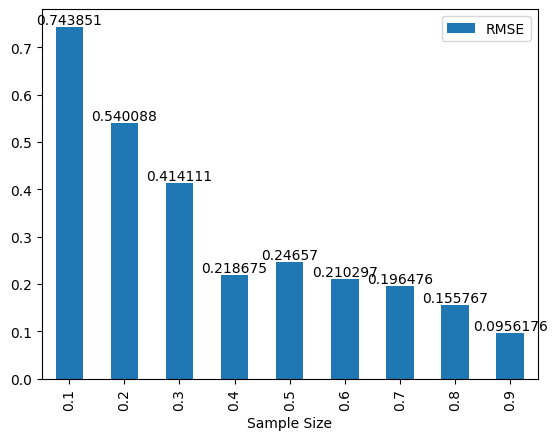

C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\599085055.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\599085055.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = 

<Figure size 640x480 with 0 Axes>

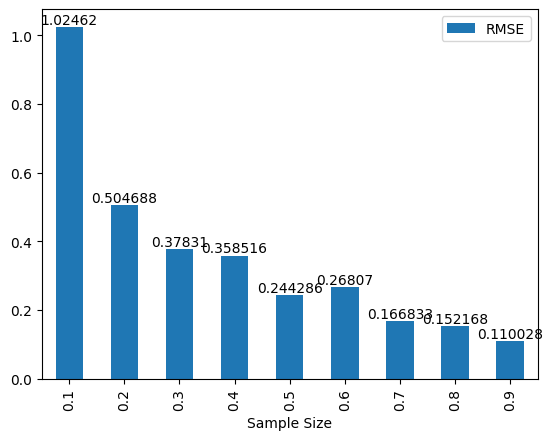

C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\599085055.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\599085055.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = 

<Figure size 640x480 with 0 Axes>

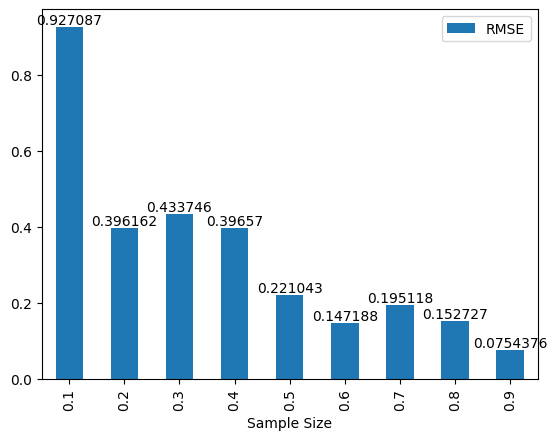

C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\599085055.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\599085055.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = 

<Figure size 640x480 with 0 Axes>

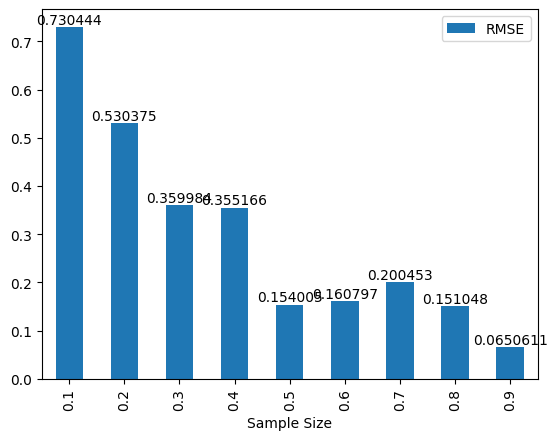

C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\599085055.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\599085055.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = 

<Figure size 640x480 with 0 Axes>

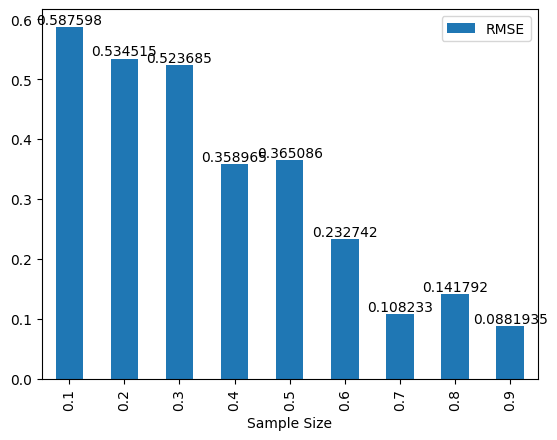

In [44]:
for _ in range(5):
    perform_test()

We see that when the S2 resolution is fixed to 14 and starting from sample size 60%, stratified sampling using H3 is reliable when it comes to reducing the dataset size while still retaining the same information on a neighborhood-level. (With very minor fluctuations in sample size 60%.)

## <font color = 'blue'> Fixed Size and Variable Resolution </font>

### <font color = 'green'>- RMSE </font>

In [45]:
s2_resolution_min = 0
s2_resolution_max = 30
sampling_frequency = 0.6

In [48]:
def perform_test():
    error = []
    s2_resolution = s2_resolution_min
    while s2_resolution <= s2_resolution_max:
        stratified_sample = group_by_s2(trips, s2_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
        random_sample_pm25 = (stratified_sample
                    .groupby('District')
                    .pm25
                    .agg(list)
                    .to_frame("pm25_list")
                    .reset_index())  # Make a list of pm25 values for each District
        random_sample_pm25['average_pm25_value'] = random_sample_pm25['pm25_list'].apply(lambda x: sum(x) / len(x))  # Find the average pm25 value per District
        random_sample_pm25.drop('pm25_list', axis = 1, inplace=True)
        for District in population_pm25["District"]:
            if District not in random_sample_pm25["District"].values:
                random_sample_pm25.loc[len(random_sample_pm25.index)] = [District, 0]
        random_sample_pm25.sort_values(by='District', inplace=True)
        random_sample_pm25.reset_index(drop=True, inplace=True)
        assert population_pm25['District'].equals(random_sample_pm25['District'])
        baseline_pm25 =    population_pm25["average_pm25_value"].values
        sampled_pm25  = random_sample_pm25["average_pm25_value"].values
        rmse = calculate_rmse(sampled_pm25, baseline_pm25)
        error.append(rmse)
        s2_resolution += 1
    S2_Performance = pd.DataFrame({'S2 Resolution':list(range(s2_resolution_min, s2_resolution_max + 1)),
                                'RMSE': error})
    plt.figure()
    ax = S2_Performance.plot(kind='bar', x='S2 Resolution', y= 'RMSE')
    ax.bar_label(ax.containers[0], color = 'black')
    plt.show()

C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\1920500407.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\1920500407.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).ap

<Figure size 640x480 with 0 Axes>

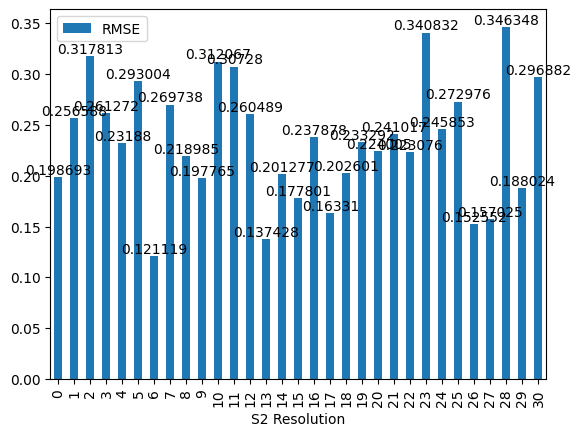

C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\1920500407.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\1920500407.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).ap

<Figure size 640x480 with 0 Axes>

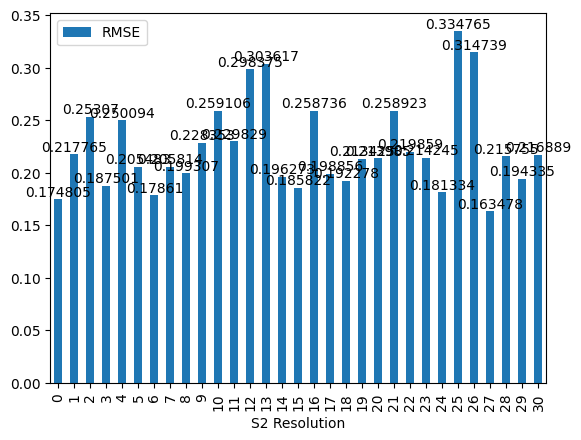

C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\1920500407.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\1920500407.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).ap

<Figure size 640x480 with 0 Axes>

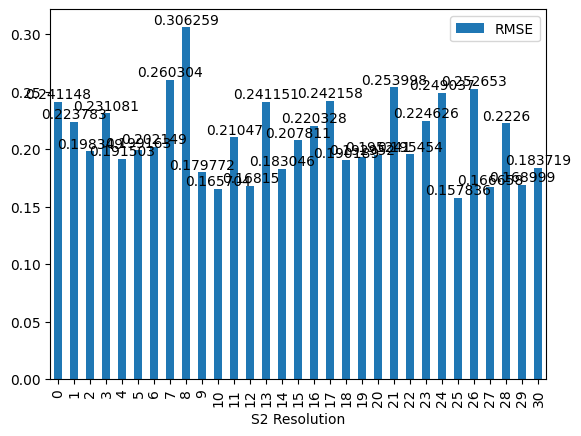

C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\1920500407.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\1920500407.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).ap

<Figure size 640x480 with 0 Axes>

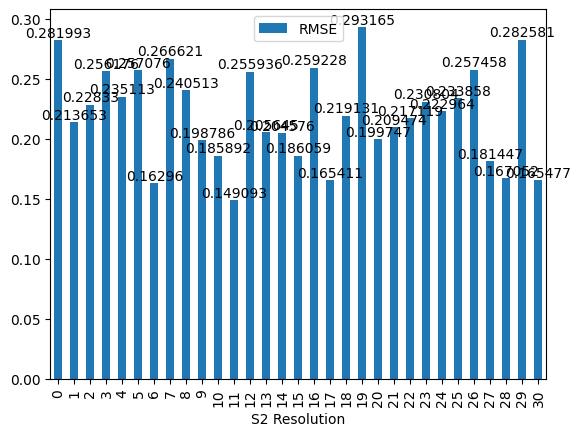

C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\1920500407.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\mohan\AppData\Local\Temp\ipykernel_2428\1920500407.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).ap

<Figure size 640x480 with 0 Axes>

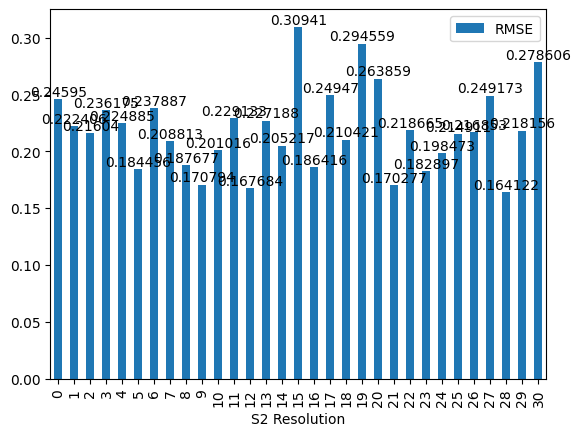

In [49]:
for _ in range(5):
    perform_test()